In [1]:
import torch
import glob
from hypso import Hypso
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import calculate_rmse, calculate_sam


In [2]:
# can be 'l1a', 'l1b', or 'l1d'
data_product = 'l1b'

In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = glob.glob(f'../data/training_{data_product}/*.nc')
print(f"Found {len(data_dir)} files.")

Using device: cpu
Found 44 files.


In [4]:
import torch.nn.functional as F

def extract_spatial_features(hsi_cube_np, window_size=3):
    """
    Expands an (H, W, B) hyperspectral cube to (H, W, 3*B) by appending 
    local neighborhood mean and standard deviation.
    """
    # Reshape to (Batch, Channels, Height, Width) for PyTorch 2D operations
    cube_t = torch.from_numpy(hsi_cube_np).float().unsqueeze(0).permute(0, 3, 1, 2)
    
    pad = window_size // 2
    
    # 1. Local Mean
    avg_pool = F.avg_pool2d(cube_t, kernel_size=window_size, stride=1, padding=pad)
    
    # 3. Concatenate (Original, Mean, Std)
    augmented_cube = torch.cat([cube_t, avg_pool], dim=1)
    
    # Return to numpy (H, W, 3*B)
    return augmented_cube.squeeze(0).permute(1, 2, 0).numpy()

In [5]:
target_total_samples = 50000
samples_per_file = target_total_samples // len(data_dir) 
sampled_data_list = []

print(f"Aiming to extract ~{samples_per_file} pixels per file.")

for file in data_dir:
    # Load Data
    try:
        satobj = Hypso(file) 
        if satobj is None: continue
        
        # Load and reshape
        match data_product:
            case 'l1a':
                data = satobj.l1a_cube.values.astype(np.float32)
            case 'l1b':
                data = satobj.l1b_cube.values.astype(np.float32)
            case 'l1d':
                data = satobj.l1d_cube.values.astype(np.float32)
            case _:
                raise ValueError(f"Unknown data product: {data_product}")
            
        data_aug = extract_spatial_features(data, window_size=3)
        
        h, w, b = data_aug.shape
        data_2d = data_aug.reshape(-1, b) # Shape: (Total_Pixels_In_Image, 120)
        
        # Random Subsampling 
        total_pixels_in_image = data_2d.shape[0]
        
        # Determine how many to take (don't take more than exists)
        n_to_take = min(samples_per_file, total_pixels_in_image)

        # Removing saturated pixels
        highest_pixel_value = np.max(data_2d)
        print(f"Highest pixel value in file {os.path.basename(file)}: {highest_pixel_value}")
        valid_pixel_mask = np.all(data_2d < highest_pixel_value, axis=1)
        data_2d = data_2d[valid_pixel_mask]
        print(f"Number of removed pixels: {total_pixels_in_image - data_2d.shape[0]}")
        total_pixels_in_image = data_2d.shape[0]
        n_to_take = min(n_to_take, total_pixels_in_image)
        
        # Generate random indices
        rng = np.random.default_rng()
        indices = rng.choice(total_pixels_in_image, size=n_to_take, replace=False)
        
        # Grab the random pixels and add to list
        sampled_pixel_subset = data_2d[indices, :]
        sampled_data_list.append(sampled_pixel_subset)
        
        print(f"File: {os.path.basename(file)} | Extracted {n_to_take} pixels.")

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Final Concatenation
if sampled_data_list:
    data = np.concatenate(sampled_data_list, axis=0)
    # Convert to torch tensor
    data = torch.from_numpy(data).float().to(device)
    
    # ----------------------------------------------------
    # ADDED: MISSING PREPROCESSING TO MATCH MFA
    # ----------------------------------------------------
    data_max = torch.max(data, dim=0).values
    data_max[data_max == 0] = 1.0 # Prevent division by zero
    
    X_scaled = data / data_max
    mean_val = torch.mean(X_scaled, dim=0)
    X_processed = X_scaled - mean_val
    
    print("-" * 30)
    print(f"Final Analysis Dataset Shape: {X_processed.shape}")
else:
    print("No data loaded.")

Aiming to extract ~1136 pixels per file.
Highest pixel value in file aeronetgalata_2025-01-02T08-18-16Z-l1b.nc: 125.7120361328125
Number of removed pixels: 1
File: aeronetgalata_2025-01-02T08-18-16Z-l1b.nc | Extracted 1136 pixels.
Highest pixel value in file algeria_2022-10-29T09-44-03Z-l1b.nc: 145.38905334472656
Number of removed pixels: 1
File: algeria_2022-10-29T09-44-03Z-l1b.nc | Extracted 1136 pixels.
Highest pixel value in file amazonia_2024-09-21T13-12-47Z-l1b.nc: 355.76715087890625
Number of removed pixels: 1
File: amazonia_2024-09-21T13-12-47Z-l1b.nc | Extracted 1136 pixels.
Highest pixel value in file annapolis_2025-08-04T15-25-40Z-l1b.nc: 188.49148559570312
Number of removed pixels: 1
File: annapolis_2025-08-04T15-25-40Z-l1b.nc | Extracted 1136 pixels.
Highest pixel value in file antarctica_2022-11-20T08-44-35Z-l1b.nc: 306.9892883300781
Number of removed pixels: 1
File: antarctica_2022-11-20T08-44-35Z-l1b.nc | Extracted 1136 pixels.
Highest pixel value in file barfire_2025-0

In [6]:
class HyperspectralAutoencoder(nn.Module):
    def __init__(self, input_dim=240, hidden_dim=16, bottleneck_dim=6):
        super(HyperspectralAutoencoder, self).__init__()
        
        # Reduced hidden_dim to 16 to make the parameter count (~8k) 
        # fairer compared to MFA (K=6, q=2 has ~4.5k params).
        
        # Encoder: 240 -> hidden -> Bottleneck
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim)
        )
        
        # Decoder: Bottleneck -> hidden -> 240
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

# Initialize Model
model = HyperspectralAutoencoder(input_dim=240, hidden_dim=16, bottleneck_dim=6).to(device)
print(model)

HyperspectralAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=240, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=240, bias=True)
  )
)


Starting training...
Epoch [10/50], Loss: 0.002285
Epoch [20/50], Loss: 0.000736
Epoch [30/50], Loss: 0.000474
Epoch [40/50], Loss: 0.000287
Epoch [50/50], Loss: 0.000216


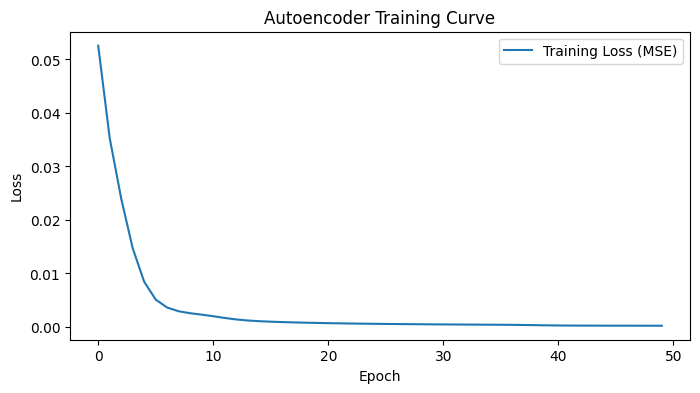

In [7]:
batch_size = 2048
# FIX: Train on X_processed, not the raw physical 'data'
dataset = TensorDataset(X_processed)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 50

print("Starting training...")
loss_history = []

model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch in dataloader:
        inputs = batch[0].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * inputs.size(0)
        
    epoch_loss /= len(dataset)
    loss_history.append(epoch_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}")

plt.figure(figsize=(8,4))
plt.plot(loss_history, label="Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder Training Curve")
plt.legend()
plt.show()

In [8]:
model.eval()
with torch.no_grad():
    # Evaluate on the normalized inputs
    X_tensor = X_processed.to(device)
    X_reconstructed_processed = model(X_tensor)
    
    # Reverse the preprocessing to get back to physical scale
    X_reconstructed_norm = X_reconstructed_processed + mean_val.to(device)
    X_reconstructed_physical = X_reconstructed_norm * data_max.to(device)
    
    # The original target MUST be the unscaled physical data
    X_original_physical = data.to(device)
    
    # Slice out only the first 120 bands (The Micro-physics)
    original_120 = X_original_physical[:, :120]
    recon_120 = X_reconstructed_physical[:, :120]
    
    rmse_score = calculate_rmse(original_120, recon_120)
    sam_score = calculate_sam(original_120, recon_120)

print("=== Autoencoder Reconstruction Benchmark Results ===")
print(f"Bottleneck (q) = 6")
print(f"RMSE (First 120 bands) = {rmse_score:.4f}")
print(f"SAM  (First 120 bands) = {sam_score:.4f} rad")

=== Autoencoder Reconstruction Benchmark Results ===
Bottleneck (q) = 6
RMSE (First 120 bands) = 3.5359
SAM  (First 120 bands) = 0.0856 rad


In [9]:
# --- CELL 7: CODE ---
# ==========================================
# 5. Save the Benchmark Model
# ==========================================
save_dir = '../models/'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'autoencoder_q6_spatial_info.pt')

torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparameters': {
        'input_dim': 240,
        'bottleneck_dim': 6
    },
    'preprocessing': {
        'data_max': data_max,
        'mean': mean_val
    },
    'metrics': {
        'rmse': rmse_score,
        'sam': sam_score
    }
}, save_path)

print(f"Autoencoder model saved to '{save_path}'")

Autoencoder model saved to '../models/autoencoder_q6_spatial_info.pt'
